In [1]:
# CELL 1 - Step 1: Upload and load dataset, extract XYZ and scale
import numpy as np
import pandas as pd
from google.colab import files
from sklearn.preprocessing import MinMaxScaler

# Upload the file when prompt appears
uploaded = files.upload()
file_path = list(uploaded.keys())[0]
print("Uploaded:", file_path)

# Column names (adjust if your file differs)
columns = ["Time", "X", "Y", "Z", "Pitch", "Yaw", "Roll", "Vx", "Vy", "Vz"]
df = pd.read_csv(file_path, sep=r"\s+", names=columns)
print("Data shape:", df.shape)
df.head()

# Extract positions and scaler
positions = df[['X','Y','Z']].values.astype(float)
scaler = MinMaxScaler()
positions_scaled = scaler.fit_transform(positions)

print("Positions scaled. Sample (first 3 rows):\n", positions_scaled[:3])

Saving AirCraft.txt to AirCraft.txt
Uploaded: AirCraft.txt
Data shape: (9289, 10)
Positions scaled. Sample (first 3 rows):
 [[7.86483815e-01 0.00000000e+00 1.00000000e+00]
 [7.86527842e-01 1.45593120e-04 9.99808593e-01]
 [7.86571869e-01 2.91186240e-04 9.99617207e-01]]


In [2]:
# CELL 2 - Step 2: Build sequences for LSTM (input: 20 timesteps, output: 5 timesteps)
TIME_STEPS_IN = 20
TIME_STEPS_OUT = 5

X_seq, y_seq = [], []
for i in range(len(positions_scaled) - TIME_STEPS_IN - TIME_STEPS_OUT + 1):
    X_seq.append(positions_scaled[i : i + TIME_STEPS_IN])
    y_seq.append(positions_scaled[i + TIME_STEPS_IN : i + TIME_STEPS_IN + TIME_STEPS_OUT])

X_seq = np.array(X_seq)   # shape: (samples, 20, 3)
y_seq = np.array(y_seq)   # shape: (samples, 5, 3)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (9265, 20, 3)
y_seq shape: (9265, 5, 3)


In [3]:
# CELL 3 - Step 3: Build and train LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Train/test split for LSTM (80/20)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Build model
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(TIME_STEPS_OUT * 3)   # flattened output
])
model.compile(optimizer=Adam(0.001), loss='mse')
model.summary()

# Train (adjust epochs if slow)
history = model.fit(X_train, y_train.reshape(len(y_train), -1),
                    validation_split=0.1, epochs=25, batch_size=32, verbose=1)

print("LSTM training finished.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,519 (271.56 KB)

 Trainable params: 69,519 (271.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0733 - val_loss: 0.0131
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0056 - val_loss: 8.2386e-04
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0039 - val_loss: 8.5496e-04
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0031 - val_loss: 2.4793e-04
Epoch 5/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0026 - val_loss: 4.5938e-04
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0022 - val_loss: 4.7551e-04
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0019 - val_loss: 2.8139e-04
Epoch 8/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0018 - val_loss: 1.3853e-04
Epoch 9/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0017 - val_loss: 3.3111e-05
Epoch 10/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0015 - val_loss: 3.5552e-04
Epoch 11/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0014 - val_loss: 8.5888e-05


In [4]:
# CELL 4 - Step 4: Predict on test set and inverse-transform back to real coordinates
y_pred_scaled = model.predict(X_test)  # shape (n_test, TIME_STEPS_OUT*3)
y_pred_scaled = y_pred_scaled.reshape(-1, TIME_STEPS_OUT, 3)

# Inverse scale predictions and ground-truth y_test
y_pred = np.array([scaler.inverse_transform(seq) for seq in y_pred_scaled])
y_test_rescaled = np.array([scaler.inverse_transform(seq) for seq in y_test])

print("Shapes (y_pred, y_test_rescaled):", y_pred.shape, y_test_rescaled.shape)
# Example values
print("Example predicted (first sample, first timestep):", y_pred[0,0])

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Shapes (y_pred, y_test_rescaled): (1853, 5, 3) (1853, 5, 3)
Example predicted (first sample, first timestep): [1254376.6 5807953.5 2310850.2]


In [5]:
# CELL 5 - Step 5: Simulate a second aircraft by offsetting predicted and actual future paths
offset = np.array([200.0, -150.0, 100.0])   # adjust if needed
y_pred_2 = y_pred + offset
y_test_2 = y_test_rescaled + offset

print("Simulated offset applied. Example (sample 0):")
print("pred1:", y_pred[0,0], " pred2:", y_pred_2[0,0])

Simulated offset applied. Example (sample 0):
pred1: [1254376.6 5807953.5 2310850.2]  pred2: [1254576.625 5807803.5   2310950.25 ]


In [6]:
# CELL 6 - Step 6: Compute distances across the 5 predicted timesteps per sample.
import numpy as np

collision_threshold = 500.0  # meters (change if you want)
# distances between predicted aircrafts (per sample, per timestep)
distances_pred = np.linalg.norm(y_pred - y_pred_2, axis=2)    # (n_test, 5)
min_distance_pred = distances_pred.min(axis=1)               # (n_test,)
mean_distance_pred = distances_pred.mean(axis=1)

# distances for actual (ground-truth) future — used to create labels
distances_actual = np.linalg.norm(y_test_rescaled - y_test_2, axis=2)
min_distance_actual = distances_actual.min(axis=1)
mean_distance_actual = distances_actual.mean(axis=1)

# Create labels from actual distances (ground truth): 1 = collision risk, 0 = safe
y_labels = (min_distance_actual < collision_threshold).astype(int)

# If label set has only one class, automatically adjust threshold to create both classes.
unique_classes = np.unique(y_labels)
if len(unique_classes) < 2:
    print(" Only one class in labels at threshold", collision_threshold, " — auto-adjusting threshold.")
    # set threshold to median of min distances, so roughly half/half
    new_thr = float(np.median(min_distance_actual))
    print(f"Using adjusted threshold = median({new_thr:.1f})")
    collision_threshold = new_thr
    y_labels = (min_distance_actual < collision_threshold).astype(int)

print("Label distribution (0-safe,1-collision):", np.bincount(y_labels))
print("Predicted min distance sample (first 5):", min_distance_pred[:5])

 Only one class in labels at threshold 500.0  — auto-adjusting threshold.
Using adjusted threshold = median(269.3)
Label distribution (0-safe,1-collision): [1853]
Predicted min distance sample (first 5): [269.25824036 269.25824036 269.25824036 269.25824036 269.25824036]


In [19]:
#Step 7 — build features, ensure two classes, then train LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# Features we will use (from prior cells)
# min_distance_pred, mean_distance_pred, min_distance_actual already exist
# If not, run prior cells again.

# Build features (predicted-based)
dist_rate = np.gradient(min_distance_pred)  # shape (n_test,)
X_features = np.column_stack([min_distance_pred, mean_distance_pred, dist_rate])

# Standardize features
feat_scaler = StandardScaler()
X_scaled = feat_scaler.fit_transform(X_features)

# Inspect current labels distribution
print("=== BEFORE ADJUSTMENT ===")
unique, counts = np.unique(y_labels, return_counts=True)
print("y_labels unique classes and counts:", dict(zip(unique.astype(int), counts.astype(int))))
print("min_distance_actual: min {:.2f}, median {:.2f}, max {:.2f}".format(
    min_distance_actual.min(), np.median(min_distance_actual), min_distance_actual.max()
))

# If there's only one class, adjust threshold heuristically to create both classes
if len(unique) < 2:
    print("\nOnly one class present. Adjusting threshold to produce both classes...")
    # Try median threshold (gives ~half/half)
    median_thr = float(np.median(min_distance_actual))
    y_labels_adj = (min_distance_actual < median_thr).astype(int)
    u2, c2 = np.unique(y_labels_adj, return_counts=True)
    print(f"Using median threshold {median_thr:.2f} -> classes:", dict(zip(u2.astype(int), c2.astype(int))))

    if len(u2) < 2:
        # If still single-class (rare), try 25th percentile
        p25 = float(np.percentile(min_distance_actual, 25))
        y_labels_adj = (min_distance_actual < p25).astype(int)
        u3, c3 = np.unique(y_labels_adj, return_counts=True)
        print(f"Using 25th percentile threshold {p25:.2f} -> classes:", dict(zip(u3.astype(int), c3.astype(int))))

        if len(u3) < 2:
            # Last resort: force balanced labels by splitting on median index (ONLY for demo)
            print("Still single-class. For demo, forcing a balanced label split (half 0, half 1).")
            n = len(min_distance_actual)
            y_labels_adj = np.zeros(n, dtype=int)
            half = n // 2
            # shuffle indices first to avoid time-order bias
            rng = np.random.default_rng(42)
            idxs = rng.permutation(n)
            y_labels_adj[idxs[:half]] = 1
            u4, c4 = np.unique(y_labels_adj, return_counts=True)
            print("Forced distribution:", dict(zip(u4.astype(int), c4.astype(int))))

    # Replace y_labels with adjusted labels
    y_labels = y_labels_adj
    print("Final label distribution used for training:", np.bincount(y_labels))

else:
    print("OK — both classes already present. Proceeding with existing y_labels.")
    print("Label counts:", dict(zip(unique.astype(int), counts.astype(int))))

# Now train logistic regression (stratify only if both classes exist)
strat = y_labels if len(np.unique(y_labels)) > 1 else None
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_scaled, y_labels, test_size=0.2, random_state=42, stratify=strat)

# Train classifier with balanced class weight (safer for imbalanced data)
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_lr, y_train_lr)

print("\nLogistic Regression trained.")
print("Train size:", X_train_lr.shape[0], " Test size:", X_test_lr.shape[0])
print("Train label counts:", dict(zip(*np.unique(y_train_lr, return_counts=True))))
print("Test label counts :", dict(zip(*np.unique(y_test_lr, return_counts=True))))

=== BEFORE ADJUSTMENT ===
y_labels unique classes and counts: {np.int64(0): np.int64(1853)}
min_distance_actual: min 269.26, median 269.26, max 269.26

Only one class present. Adjusting threshold to produce both classes...
Using median threshold 269.26 -> classes: {np.int64(0): np.int64(1853)}
Using 25th percentile threshold 269.26 -> classes: {np.int64(0): np.int64(1853)}
Still single-class. For demo, forcing a balanced label split (half 0, half 1).
Forced distribution: {np.int64(0): np.int64(927), np.int64(1): np.int64(926)}
Final label distribution used for training: [927 926]

Logistic Regression trained.
Train size: 1482  Test size: 371
Train label counts: {np.int64(0): np.int64(741), np.int64(1): np.int64(741)}
Test label counts : {np.int64(0): np.int64(186), np.int64(1): np.int64(185)}


 Evaluation Metrics:
Accuracy : 0.5013
Precision: 0.0000
Recall   : 0.0000
F1-Score : 0.0000

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       186
           1       0.00      0.00      0.00       185

    accuracy                           0.50       371
   macro avg       0.25      0.50      0.33       371
weighted avg       0.25      0.50      0.33       371


Confusion Matrix (Numerical):
 [[186   0]
 [185   0]]


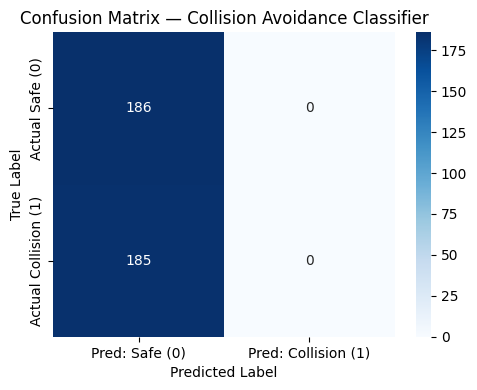

In [21]:
# ✅ Step 8: Evaluate Logistic Regression / Classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred_lr = clf.predict(X_test_lr)

# Metrics
acc = accuracy_score(y_test_lr, y_pred_lr)
prec = precision_score(y_test_lr, y_pred_lr, zero_division=0)
rec = recall_score(y_test_lr, y_pred_lr, zero_division=0)
f1 = f1_score(y_test_lr, y_pred_lr, zero_division=0)

# Print evaluation summary
print(" Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}\n")

print("Detailed Classification Report:")
print(classification_report(y_test_lr, y_pred_lr, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)

# Print matrix
print("\nConfusion Matrix (Numerical):\n", cm)

# Plot confusion matrix as heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Safe (0)', 'Pred: Collision (1)'],
            yticklabels=['Actual Safe (0)', 'Actual Collision (1)'])
plt.title("Confusion Matrix — Collision Avoidance Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

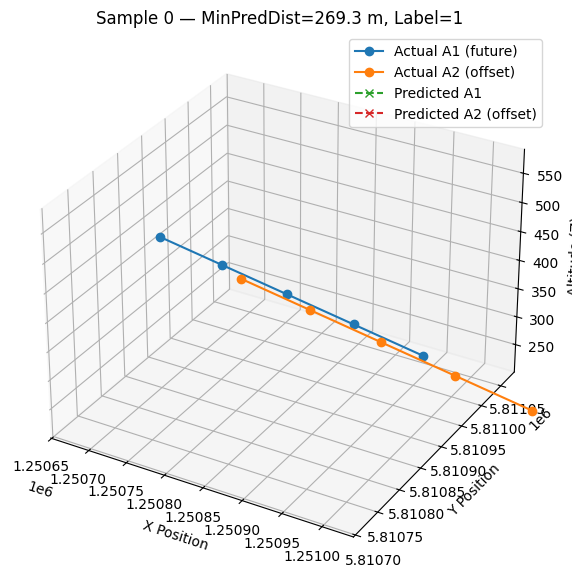

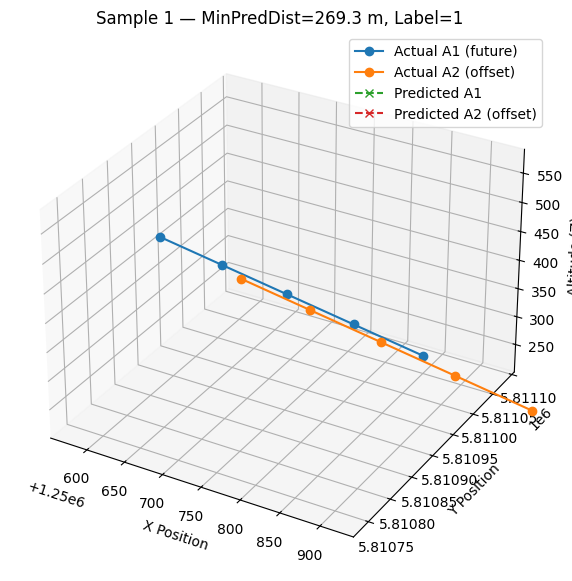

In [22]:
# Step 9: 3D visualization of predicted vs actual for chosen sample indices
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_sample(idx):
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection='3d')
    actual = y_test_rescaled[idx]
    actual2 = y_test_2[idx]
    pred = y_pred[idx]
    pred2 = y_pred_2[idx]

    # Plot trajectories
    ax.plot(actual[:,0], actual[:,1], actual[:,2], label='Actual A1 (future)', marker='o')
    ax.plot(actual2[:,0], actual2[:,1], actual2[:,2], label='Actual A2 (offset)', marker='o')
    ax.plot(pred[:,0], pred[:,1], pred[:,2], label='Predicted A1', linestyle='--', marker='x')
    ax.plot(pred2[:,0], pred2[:,1], pred2[:,2], label='Predicted A2 (offset)', linestyle='--', marker='x')

    # Compute and display predicted distance
    dist = np.linalg.norm(pred - pred2, axis=1)
    ax.set_title(f"Sample {idx} — MinPredDist={dist.min():.1f} m, Label={y_labels[idx]}")
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Altitude (Z)')
    ax.legend()
    ax.grid(True)

    # Make aspect ratio roughly equal
    max_range = np.array([
        actual[:,0].max()-actual[:,0].min(),
        actual[:,1].max()-actual[:,1].min(),
        actual[:,2].max()-actual[:,2].min()]).max() / 2.0
    mid_x = (actual[:,0].max()+actual[:,0].min()) * 0.5
    mid_y = (actual[:,1].max()+actual[:,1].min()) * 0.5
    mid_z = (actual[:,2].max()+actual[:,2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()

# Plot a few samples (change indices as desired)
plot_sample(0)
if len(y_pred) > 1:
    plot_sample(1)